In [19]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, IntSlider


def apply_window_level(np_image, window, level):
    """
    Adjust the image contrast using the specified window and level.

    Parameters:
    - np_image: NumPy array of the CT image.
    - window: The width of the intensity window.
    - level: The center of the intensity window.

    Returns:
    - Adjusted NumPy array with values scaled to [0, 255].
    """
    lower_bound = level - window / 2
    upper_bound = level + window / 2
    windowed_image = np.clip(np_image, lower_bound, upper_bound)
    windowed_image = np.interp(
        windowed_image, (lower_bound, upper_bound), (0, 255))
    return windowed_image.astype(np.uint8)


def noiseImage(image, k):
    """
    Calculate the local noise image using a local standard deviation calculation.

    Parameters:
        image: 2D numpy array representing the image slice.
        k: The radius of the neighborhood used for calculating the standard deviation.

    Returns:
        2D numpy array representing the local noise image.
    """
    # Convert the numpy array to a SimpleITK image
    sitkImage = sitk.GetImageFromArray(image)

    # Use Gaussian smoothing to approximate local mean
    meanFilter = sitk.SmoothingRecursiveGaussianImageFilter()
    meanFilter.SetSigma(k)
    meanImage = meanFilter.Execute(sitkImage)

    # Calculate the squared image
    squaredImage = sitk.Square(sitkImage)

    # Calculate mean of squared image
    meanSquaredImage = meanFilter.Execute(squaredImage)

    # Calculate the standard deviation image: sqrt(E[X^2] - (E[X])^2)
    stdDevImage = sitk.Sqrt(meanSquaredImage - sitk.Square(meanImage))

    # Convert the SimpleITK image back to a numpy array
    noiseNumpyImage = sitk.GetArrayFromImage(stdDevImage)

    return noiseNumpyImage

# Function to save an image or plot
def save_figure(path, title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.savefig(path)
    plt.close()
    print(f"Saved image as: {path}")


# def plot_slice(slice_index):
#     plt.figure(figsize=(10, 5))
#     plt.imshow(np_image[slice_index, :, :], cmap='gray')
#     plt.colorbar()
#     plt.title(f'Slice Index: {slice_index}')
#     plt.show()


################################################################
################################################################
# READ IN IMAGE IN ITK_IMAGE
imagePath = '/Users/tunokmondol/Documents/Work/UHN/Codes/files/doseBoostedImage.mha'
itkImage = sitk.ReadImage(imagePath)
npImage = sitk.GetArrayFromImage(itkImage)

# Check image shape directly from npImage
print("Shape of npImage:", npImage.shape)

# Create interactive widgets
slice_slider = IntSlider(min=0, max=npImage.shape[0]-1, step=1, value=67, description="Slice Index")
roi_x = IntSlider(min=0, max=npImage.shape[2]-1, step=1, value=38, description='ROI X')
roi_y = IntSlider(min=0, max=npImage.shape[1]-1, step=1, value=46, description='ROI Y')
roi_width = IntSlider(min=1, max=100, step=1, value=37, description='Width')
roi_height = IntSlider(min=1, max=100, step=1, value=35, description='Height')


Shape of npImage: (129, 122, 177)


In [11]:
# Function to display the image slice and the ROI
def plot_slice(slice_index, roi_x, roi_y, roi_width, roi_height):
    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    image_slice = npImage[:, :, slice_index]
    plt.imshow(image_slice, cmap='gray')
    plt.colorbar()
    # Draw rectangle on the image
    rect = plt.Rectangle((roi_x, roi_y), roi_width, roi_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
    # Calculate and print the total signal within ROI
    roi = image_slice[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]
    total_signal = np.sum(roi)
    print("Total signal in ROI:", total_signal)


# Setup interact
interact(plot_slice, slice_index=slice_slider, roi_x=roi_x, roi_y=roi_y, roi_width=roi_width, roi_height=roi_height)

interactive(children=(IntSlider(value=67, description='Slice Index', max=128), IntSlider(value=38, description…

<function __main__.plot_slice(slice_index, roi_x, roi_y, roi_width, roi_height)>

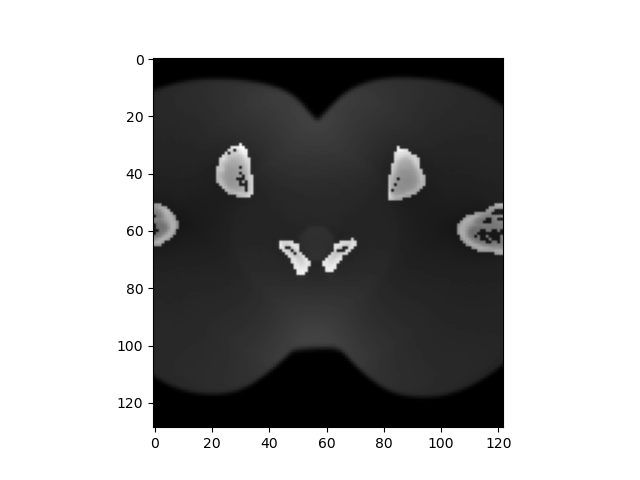

In [22]:
%matplotlib widget
from matplotlib.widgets import RectangleSelector
from IPython.display import display


def line_select_callback(eclick, erelease):
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    print("Rectangle from ({}, {}) to ({}, {})".format(x1, y1, x2, y2))
    sub_image = npImage[current_slice, y1:y2, x1:x2]
    total_signal = np.sum(sub_image)
    print("Total signal in ROI:", total_signal)

def toggle_selector(event):
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print('RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print('RectangleSelector activated.')
        toggle_selector.RS.set_active(True)

fig, ax = plt.subplots()
current_slice = 67  # Adjust based on your data
ax.imshow(npImage[:, :, current_slice], cmap='gray')
toggle_selector.RS = RectangleSelector(ax, line_select_callback,
                                       useblit=True,
                                       button=[1],  # left mouse button
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
fig.canvas.mpl_connect('key_press_event', toggle_selector)
plt.show()